In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from random import randint
import matplotlib.patches as mpatch
from matplotlib import colors as mcolors
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
import pickle 
from qtree import Leaf, QuadTree

In [3]:
path = Path('/data/Datasets/EIPH_WSI/')
database = Database()
database.open(str(path/'EIPH.sqlite'))
getslides = """SELECT uid, filename FROM Slides"""

database.execute(getslides).fetchall()

[(1, '01_EIPH_563479 Berliner Blau.svs'),
 (2, '02_EIPH_574162 berliner blau.svs'),
 (3, '03_EIPH_566933 R Berliner Blau neu.svs'),
 (4, '04_EIPH_567017 Berliner Blau.svs'),
 (5, '05_EIPH_569923 Berliner Blau.svs'),
 (6, '07_EIPH_574882 Berliner Blau-001.svs'),
 (7, '27_EIPH_571557 berliner blau.svs'),
 (8, '31_EIPH_568354 Berliner Blau.svs'),
 (9, '11_EIPH_575697 Berliner Blau.svs'),
 (10, '29_EIPH_566481 L Turnbull blue.svs'),
 (11, '28_EIPH_569948 L Turnbull blue.svs'),
 (12, '14_EIPH_568381 Turnbull blue.svs'),
 (13, '15_EIPH_568320 Turnbull blue.svs'),
 (14, '15_EIPH_568320 berliner blau.svs'),
 (15, '20_EIPH_576150 Turnbull blue.svs'),
 (16, '20_EIPH_576150 berliner blau.svs'),
 (17, '07_EIPH_574882 left lung Turnbull blue.svs'),
 (18, '08_EIPH_574999 R Turnbull blue.svs'),
 (19, '09_EIPH_563417 L Turnbull blue.svs'),
 (20, '10_EIPH_563417 R Turnbull blue-002.svs'),
 (21, '22_EIPH_575216 Turnbull blue.svs'),
 (22, '23_EIPH_563476 Turnbull blue.svs'),
 (23, '26_EIPH_566482 L Berli

In [4]:
currslide, filename = database.execute(getslides).fetchall()[20]
#currslide, filename = database.execute(getslides).fetchall()[9]

In [5]:
filename

'22_EIPH_575216 Turnbull blue.svs'

In [20]:
database.loadIntoMemory(currslide)

check = True if 'erliner' in filename else False
slidetype = 'Berliner Blau/' if check else 'Turnbull Blue/'

slide = openslide.open_slide(str(path / slidetype / filename))
level = 1#slide.level_count - 1
level_dimension = slide.level_dimensions[level]
down_factor = slide.level_downsamples[level]

basepic = np.array(slide.read_region(location=(0, 0), level=level, size=level_dimension))
basepic = basepic[:, :, :3] # just rgb 

Loading DB into memory ...


In [21]:
slide.level_dimensions

((32399, 33965), (8099, 8491), (2024, 2122))

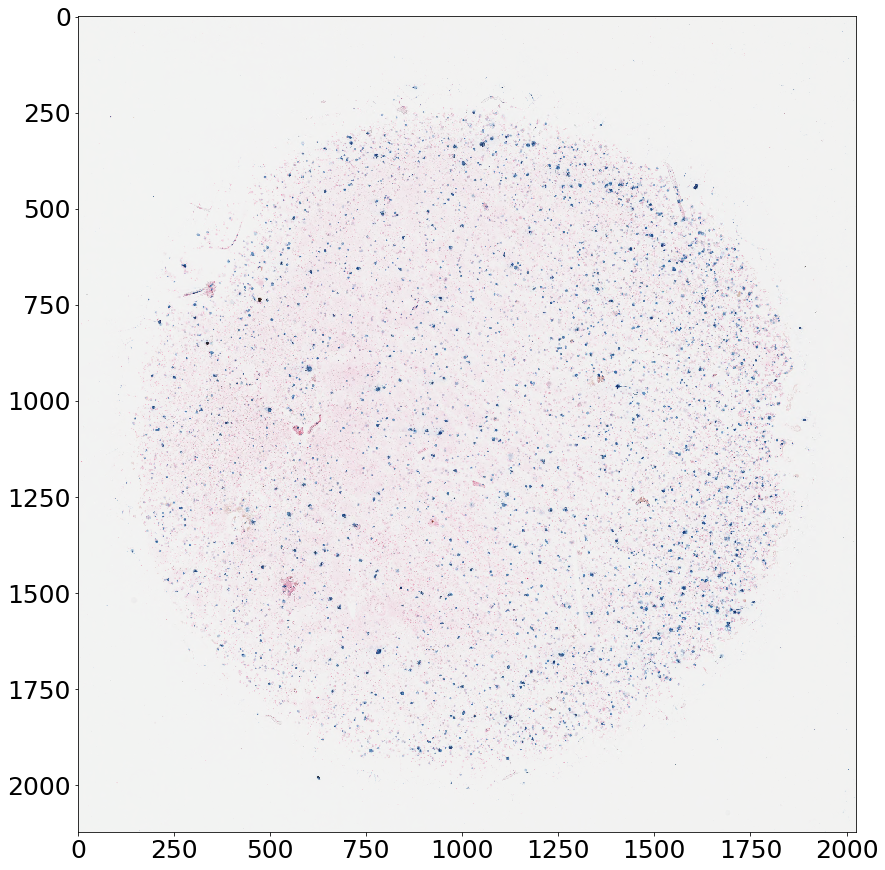

In [23]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(basepic)

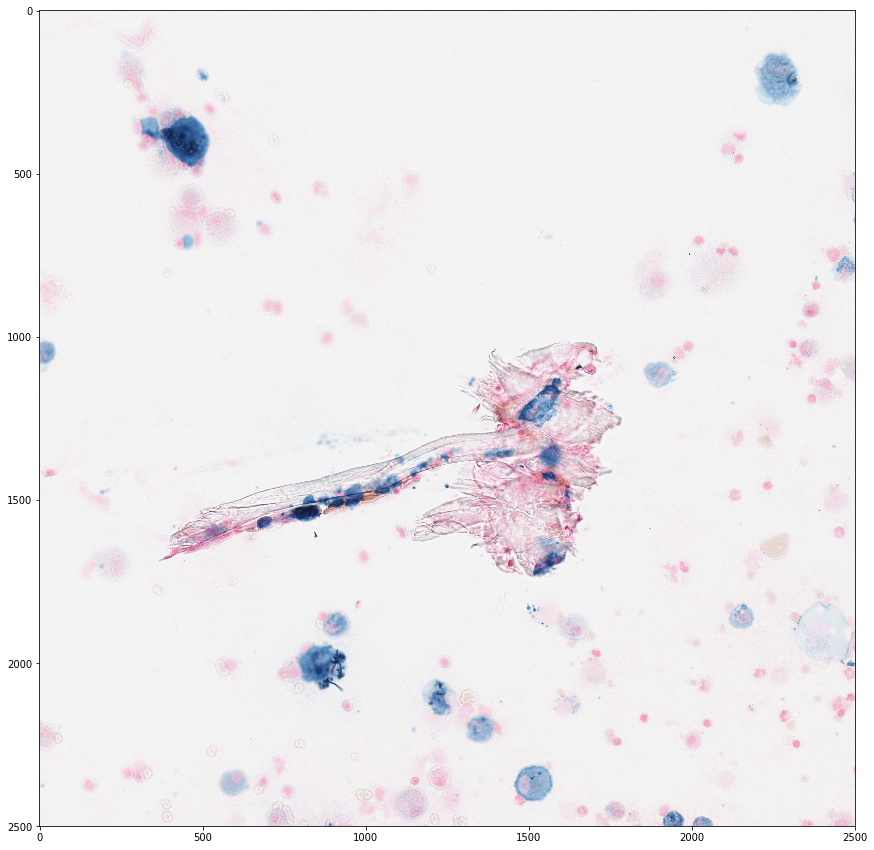

In [94]:
w,h = slide.level_dimensions[0]

sub_image = np.array(slide.read_region(location=(4000, 10000), level=0, size=(2500, 2500)))
sub_image = sub_image[:, :, :3] # just rgb 

fig = plt.figure(figsize=(15, 15))
plt.imshow(sub_image)

In [36]:
classes = {3: 0, 4: 1, 5: 2, 6: 3, 7: 4}
probability = [1, 1, 1, 1, 1]

In [37]:
data = []
for id, annotation in database.annotations.items():
    if annotation.labels[0].classId in classes:       
    
        d = int(2 * annotation.r / down_factor)
        x = int((annotation.x1 - annotation.r) / down_factor)
        y = int((annotation.y1 - annotation.r) / down_factor)
        label = classes[annotation.labels[0].classId]

        leaf =  Leaf(x,y,str(label), probability[label])
        data.append(leaf)

In [38]:
elements_per_class = [len([d.x for d in data if d.label == str(classes[key])]) for key in classes]
elements_per_class, max(elements_per_class)

([1639, 2566, 1818, 1066, 6], 2566)

In [39]:
sampling_factor = [max(elements_per_class) / e for e in elements_per_class]
sampling_factor

[1.565588773642465,
 1.0,
 1.4114411441144115,
 2.407129455909944,
 427.6666666666667]

In [40]:
print('Cells: {}'.format(len(data)))
print("Label\t Count \t Prob \t\t Inv")
for key, sf in zip(classes,sampling_factor):
    number_of_elements = len([d.x for d in data if d.label == str(classes[key])])
    class_probability = number_of_elements / len(data)
    sample_probability = sf / sum(sampling_factor)
    print('{} \t {} \t {:1.4f}% \t {:1.4f}%'.format(classes[key],
                                  number_of_elements,
                                  class_probability, sample_probability))
    
    # set new probability
    for leaf in data:
        if leaf.label == str(classes[key]) : leaf.priority = sample_probability

Cells: 7095
Label	 Count 	 Prob 		 Inv
0 	 1639 	 0.2310% 	 0.0036%
1 	 2566 	 0.3617% 	 0.0023%
2 	 1818 	 0.2562% 	 0.0033%
3 	 1066 	 0.1502% 	 0.0055%
4 	 6 	 0.0008% 	 0.9853%


In [41]:
mins = (0,0)
maxs = basepic.shape[:2]
maxs

(8491, 8099)

In [42]:
def divide_by_depth(o: QuadTree):
    return o.depth > 0

In [43]:
def divide_by_elements(o: QuadTree):
    return len(o.data) > 300

In [44]:
def count_metric(o: QuadTree):
    return [len(c.data) for c in o.children]

In [45]:
def eiph_metric(o: QuadTree):
    labels = [np.mean([int(d.label) for d in c.data]) for c in o.children]
    return labels

In [46]:
def sample_metric(o: QuadTree):
    return [np.sum([d.priority for d in c.data]) for c in o.children]

In [47]:
len(data)

7095

In [48]:
tree = QuadTree(data, mins, maxs, depth=5, divide_by=divide_by_depth, metric_func=sample_metric)

In [ ]:
'''
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
'''
plt.rcParams["font.size"] = 25

fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(wspace=0.1, hspace=0.15,
                    left=0.1, right=0.9,
                    bottom=0.05, top=0.9)

for level in range(1, 5):
    ax = fig.add_subplot(2, 2, level, xticks=[], yticks=[])
    ax.imshow(basepic, aspect='auto')
    if level > 1:
        for key, c in zip(classes, ['b','g','r','c','m']):
            x = [d.x for d in data if d.label == str(classes[key])]
            y = [d.y for d in data if d.label == str(classes[key])]
            #ax.scatter(x, y, marker='x', label=str(classes[key]))
            ax.scatter(x, y, facecolors='none', edgecolors=c, s=10, label=str(classes[key]))
            ax.legend(scatterpoints=1, title='Label', bbox_to_anchor=(1.1, 0.5), fancybox=True, shadow=True)
        tree.draw_rectangle(ax, depth=level - 1, prob=len(tree.data), use_percentages=False)
    else:
        tree.draw_rectangle(ax, depth=level - 1, prob=len(tree.data))
    ax.set_title('level %i' % level)
    
    
# width as measured in inkscape
width = 3.487
height = width / 1.618
#fig.set_size_inches(width, height)  
    
fig.suptitle('{}'.format(filename))
plt.show()

fig.savefig('plot_metric.pdf')
fig.savefig('plot_metric.png')

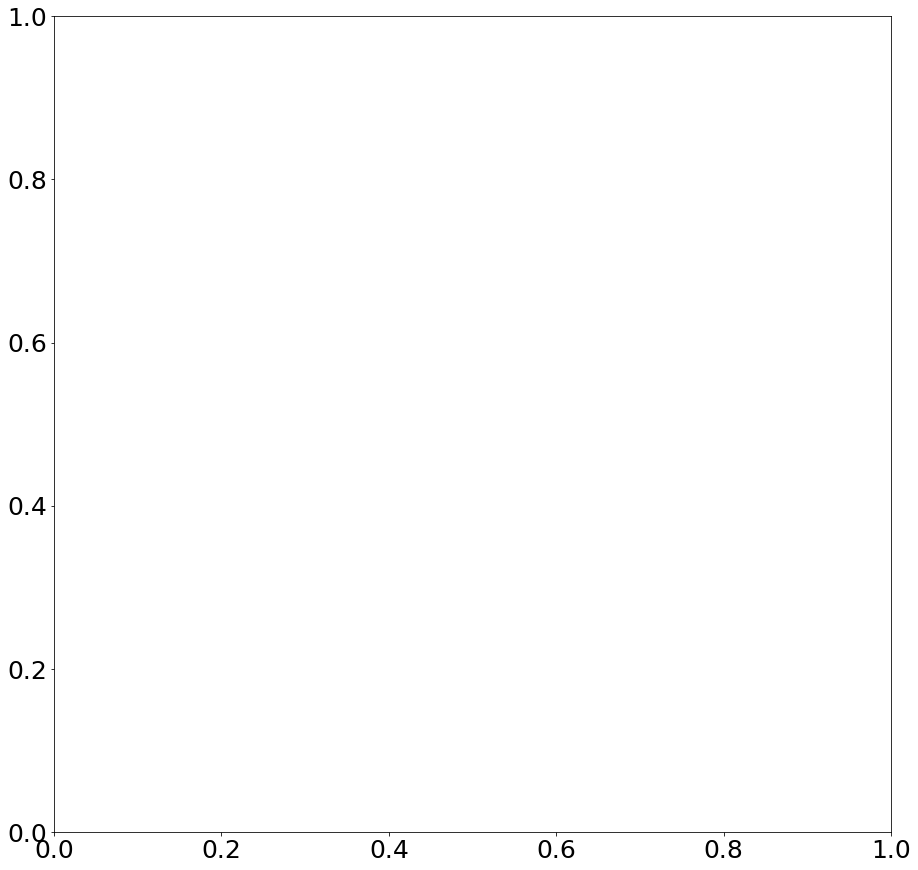

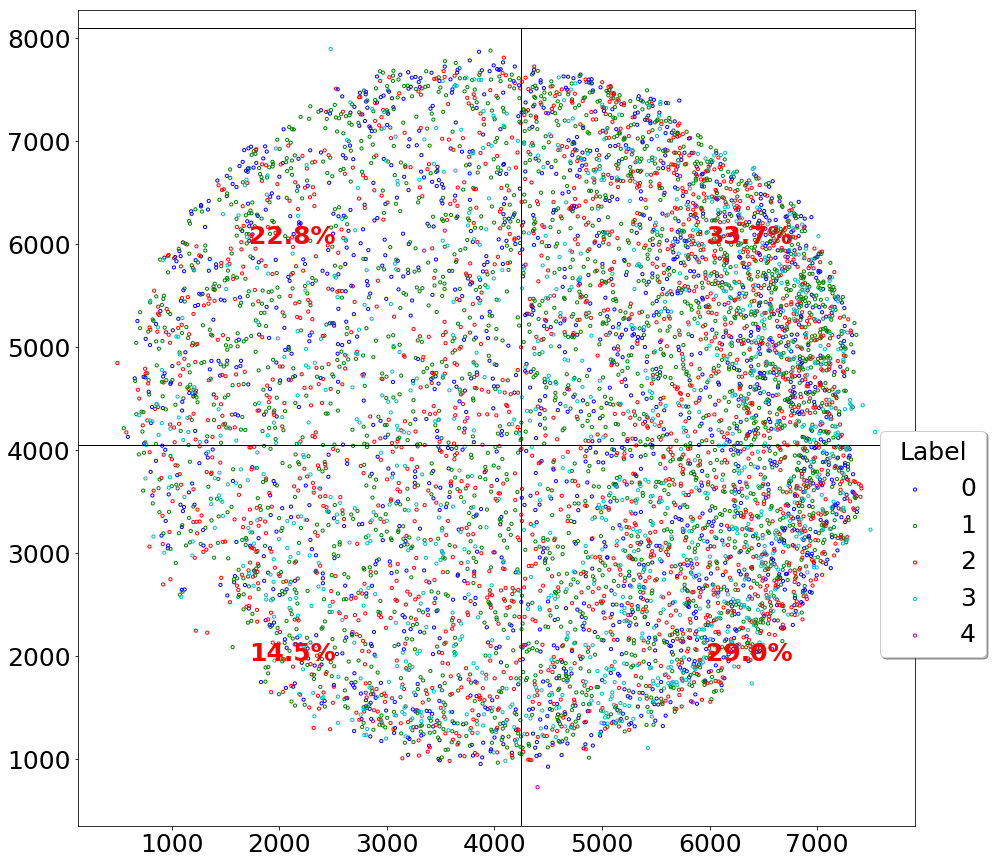

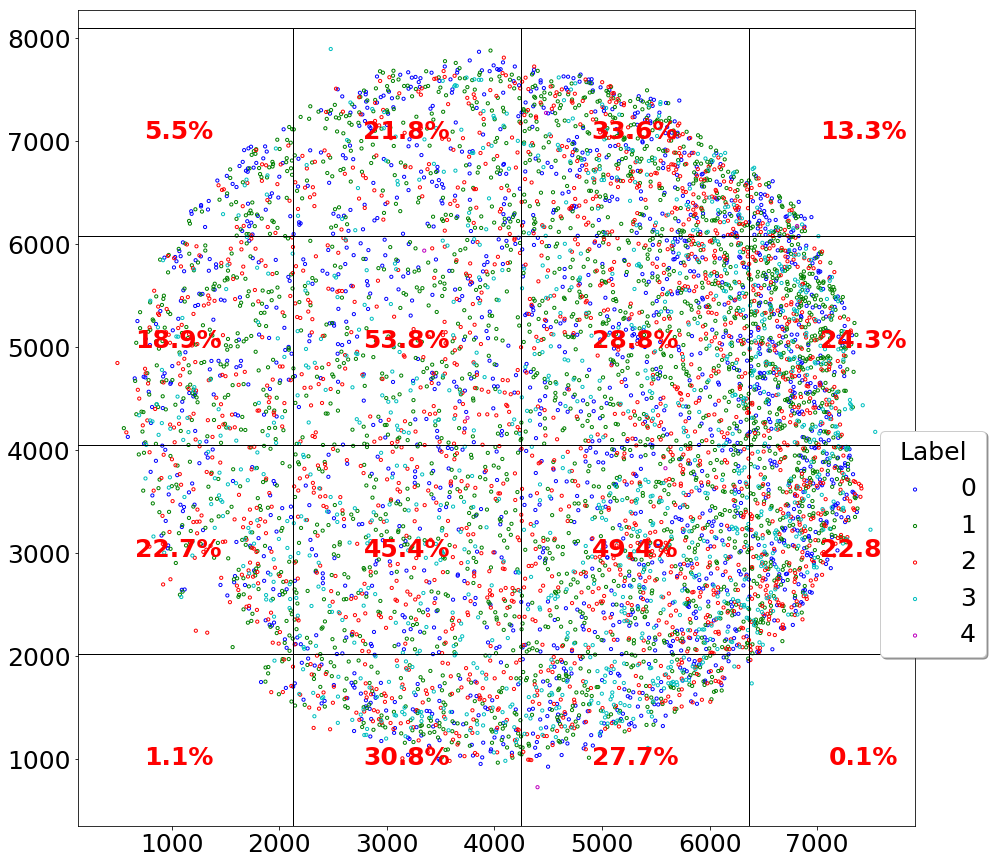

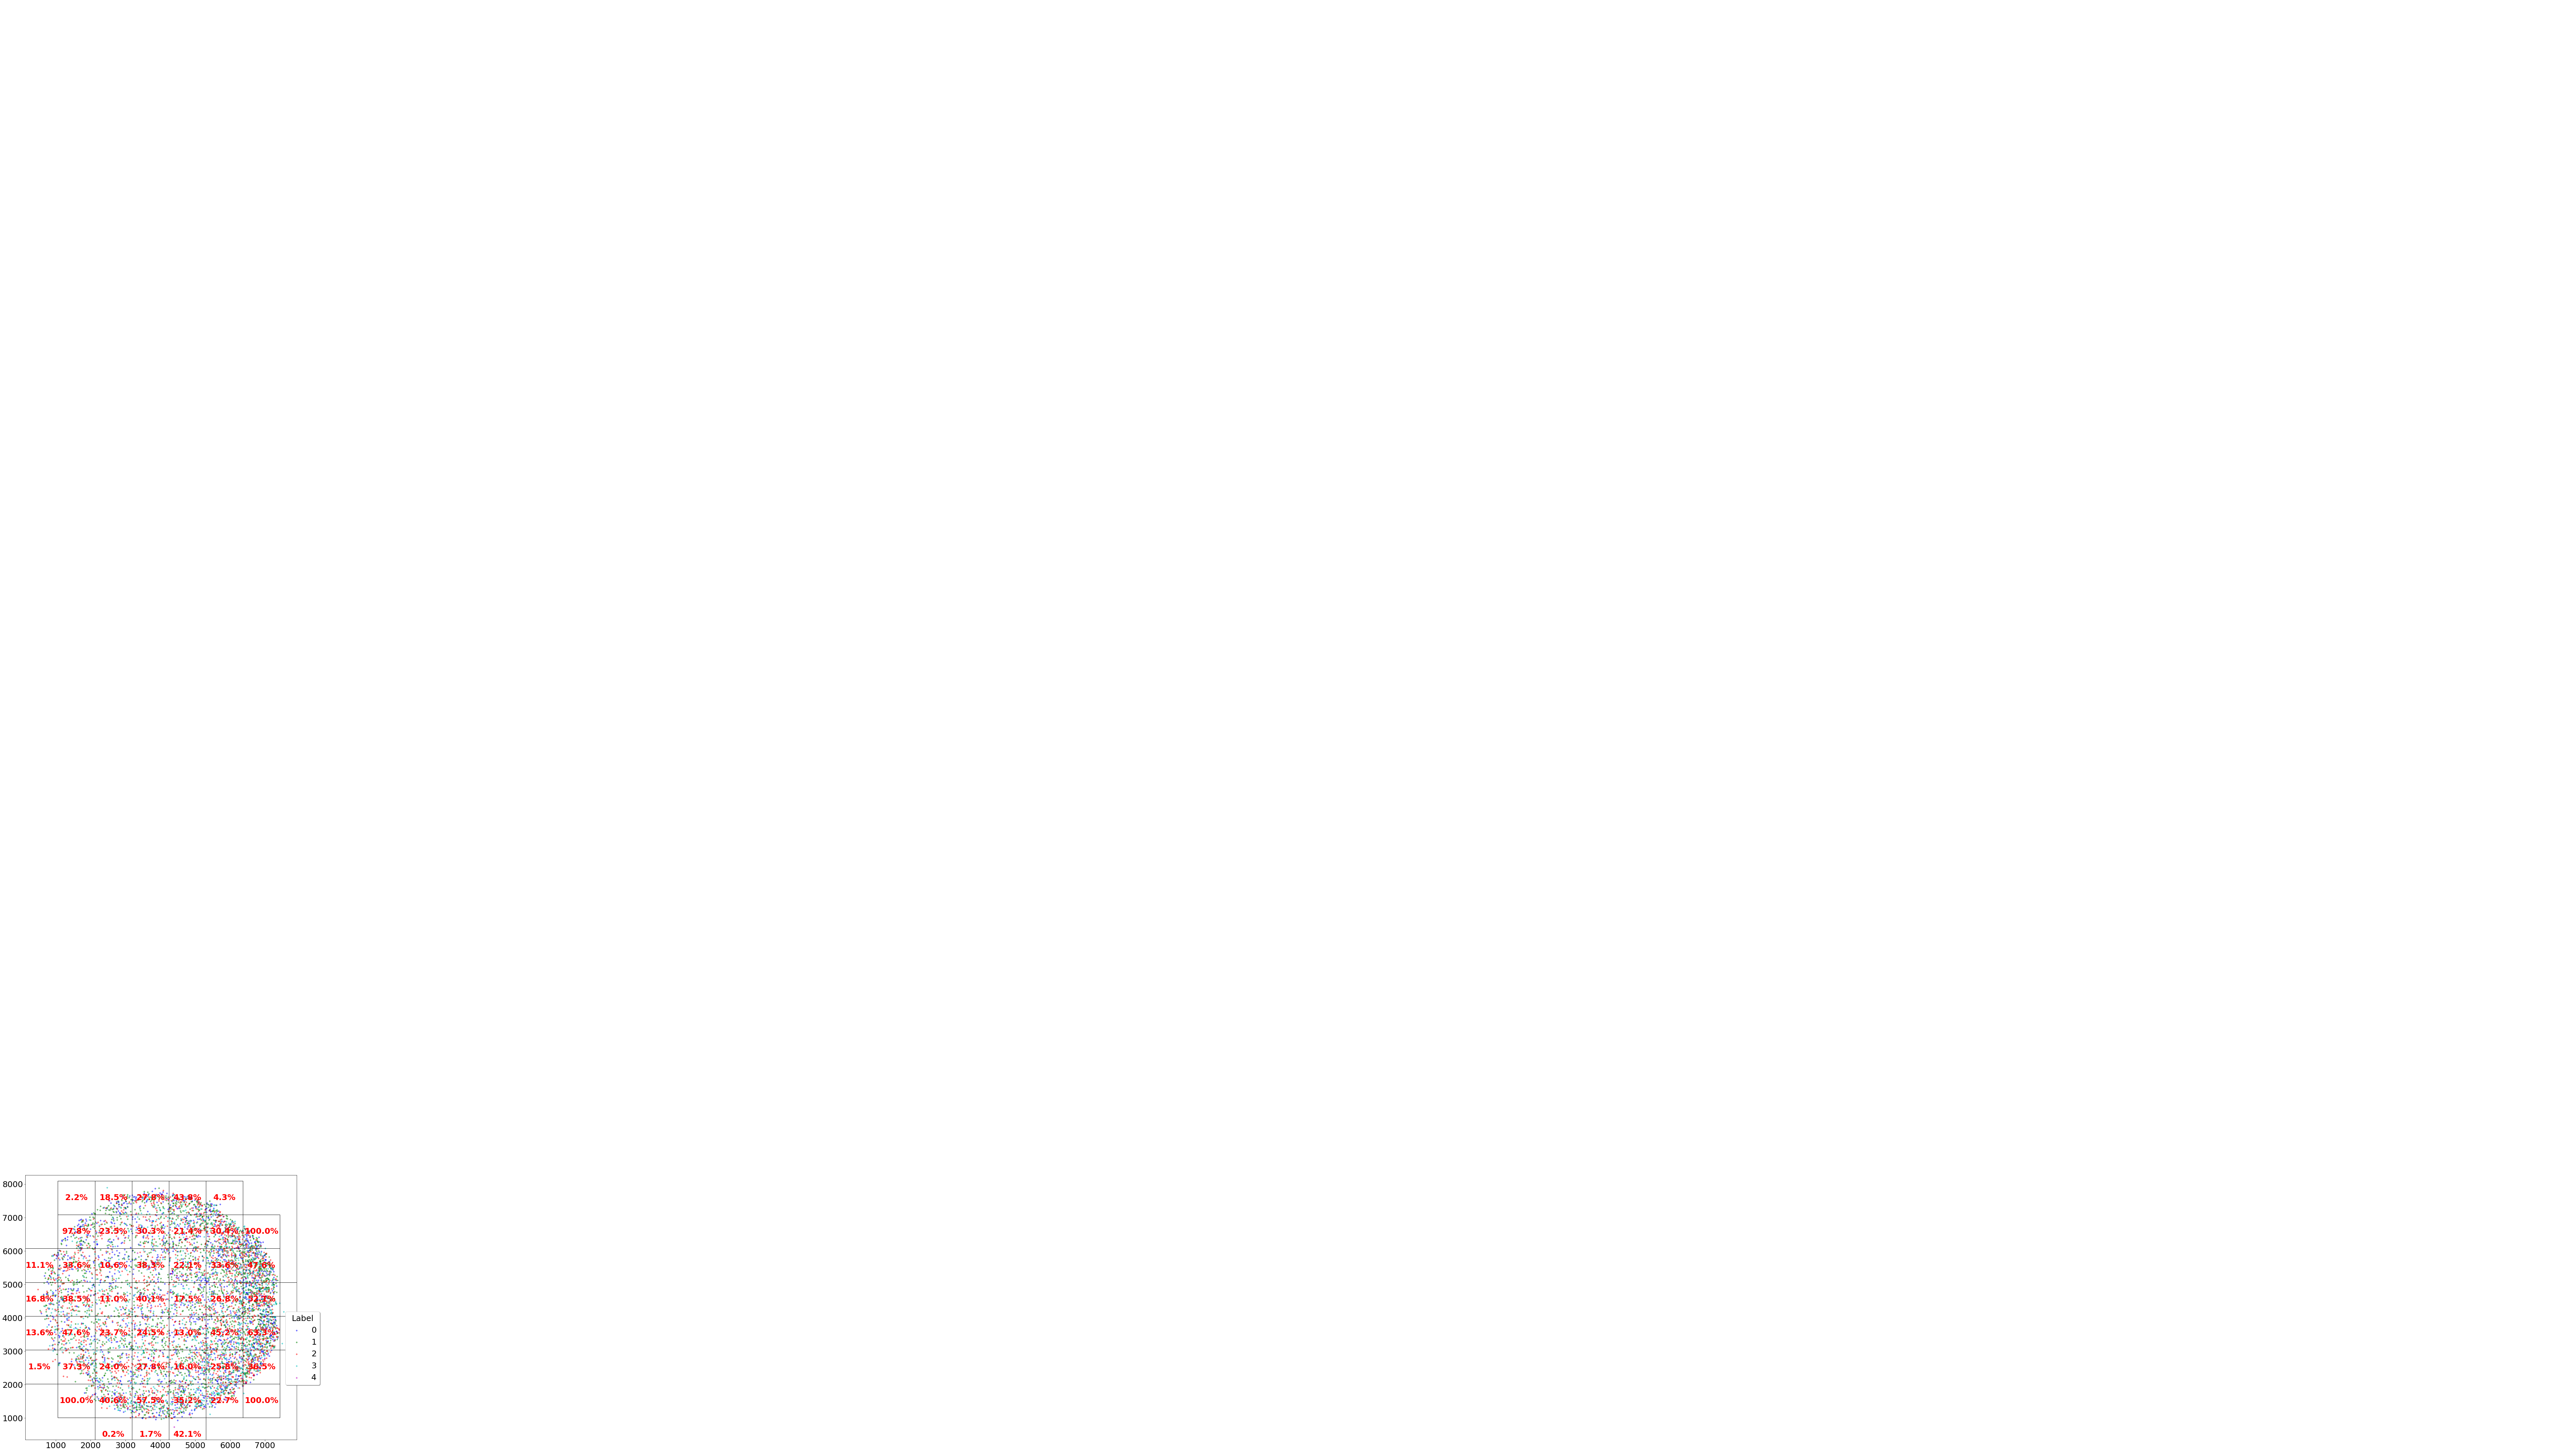

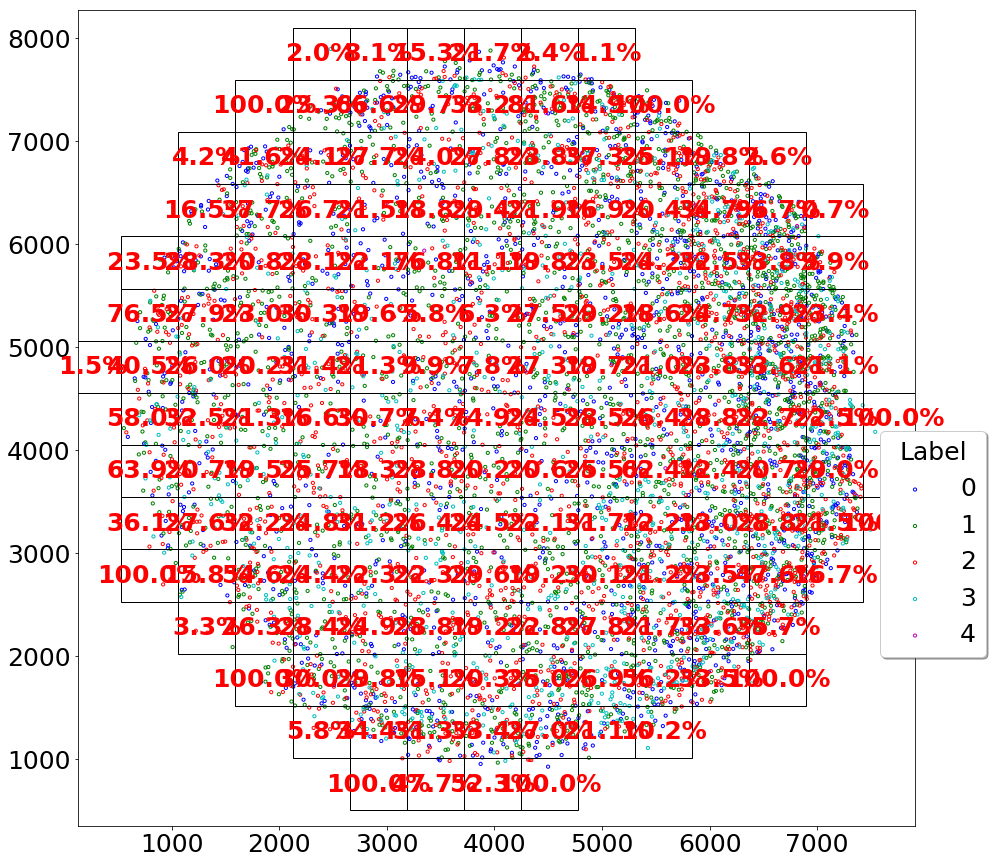

In [59]:
plt.rcParams["font.size"] = 25

for level in range(1, 6):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111)
    #ax.imshow(basepic, aspect='auto')
    if level > 1:
        for key, c in zip(classes, ['b','g','r','c','m']):
            x = [d.x for d in data if d.label == str(classes[key])]
            y = [d.y for d in data if d.label == str(classes[key])]
            #ax.scatter(x, y, marker='x', label=str(classes[key]))
            ax.scatter(x, y, facecolors='none', edgecolors=c, s=10, label=str(classes[key]))
            ax.legend(scatterpoints=1, title='Label', bbox_to_anchor=(1.1, 0.5), fancybox=True, shadow=True)
        tree.draw_rectangle(ax, depth=level - 1, prob=len(tree.data), use_percentages=True)
    #else:
        #tree.draw_rectangle(ax, depth=level - 1, prob=len(tree.data))
    #ax.set_title('level %i' % level)   
    fig.savefig('plot_{}_sampling.pdf'.format(level))
    #fig.savefig('plot_{}_sampling.png'.format(level))

In [51]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick]

In [463]:
inference_data = pickle.load(open( "../inference_results.p", "rb" ))

In [464]:
data_inf = np.array(inference_data[filename])
data_inf.shape

(22131, 6)

In [465]:
data_inf = non_max_suppression_fast(data_inf, 0.4)

data_inf_leaf = []
for x,y,w,h, pred, score in data_inf:
    if score > 0.2:
        leaf = Leaf(int(x),int(y),int(pred), score)
        data_inf_leaf.append(leaf)

In [466]:
len(data_inf_leaf)

4761

In [468]:
tree_inf = QuadTree(data_inf_leaf, mins, maxs, depth=3, divide_by=divide_by_elements, metric_func=eiph_mretric)

In [469]:
filename

'01_EIPH_563479 Berliner Blau.svs'

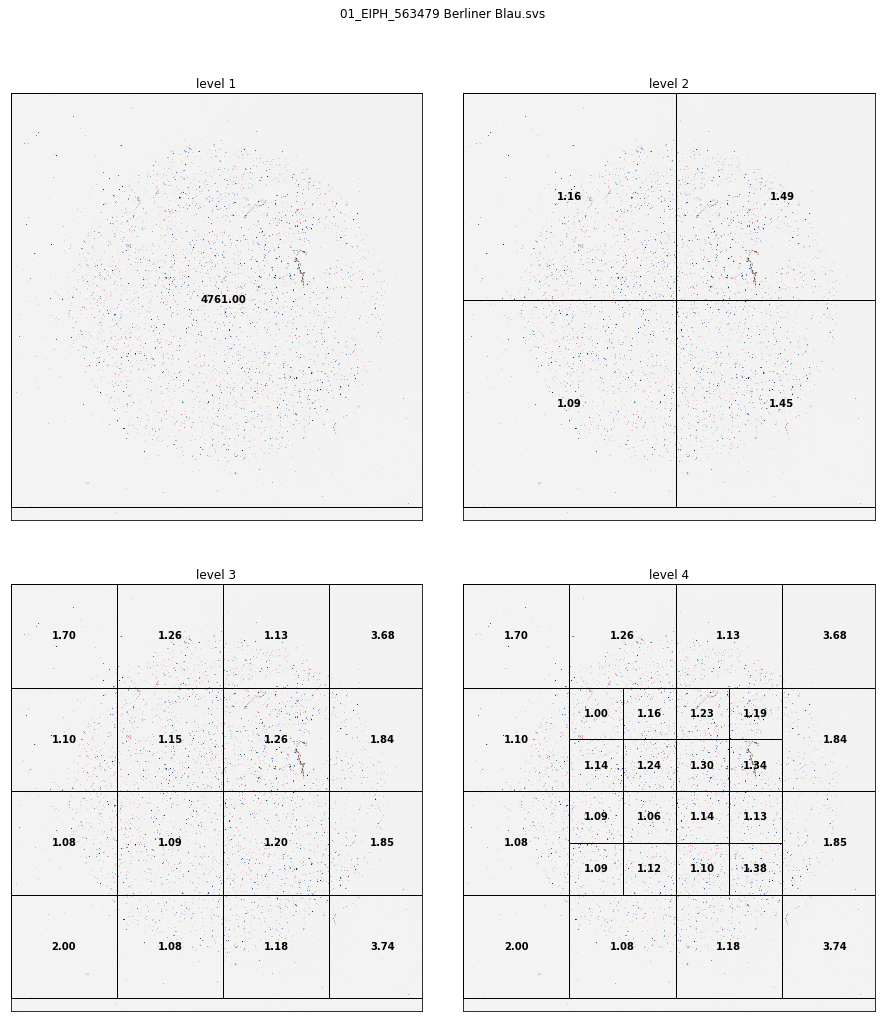

In [470]:
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(wspace=0.1, hspace=0.15,
                    left=0.1, right=0.9,
                    bottom=0.05, top=0.9)

for level in range(1, 5):
    ax = fig.add_subplot(2, 2, level, xticks=[], yticks=[])
    ax.imshow(basepic, aspect='auto')
    if level > 1:
        for key, c in zip(classes, ['b','g','r','c','m']):
            x = [d.x for d in data if d.label == str(classes[key])]
            y = [d.y for d in data if d.label == str(classes[key])]
            #ax.scatter(x, y, marker='x')
            #ax.scatter(x, y, facecolors='none', edgecolors=c, s=10)
    tree_inf.draw_rectangle(ax, depth=level - 1, prob=len(tree_inf.data))
    ax.set_title('level %i' % level)

fig.suptitle('{}'.format(filename))
plt.show()